In [1]:
import io
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time, TimeDelta


In [2]:
def get_fink_data(objectId='ZTF23abdhvou'):
    r = requests.post(
        'https://fink-portal.org/api/v1/objects',
        json={
            'objectId': objectId,
            'output-format': 'json',
            'withupperlim': 'True',
        }
    )

    # Format output in a DataFrame
    pdf = pd.read_json(io.BytesIO(r.content))
    return pdf

In [3]:
def plot_lc(pdf):
    """ Plot photometry contains in an alert
    
    Parameters
    ----------
    pdf: pandas DataFrame
        Pandas DataFrame with single alert row
    """
    fig = plt.figure(figsize=(8, 3))

    # Colors to plot
    colordic = {1: 'C0', 2: 'C1'}

    # Labels of ZTF filters
    filtdic = {1: 'g', 2: 'r'}

    for filt in np.unique(pdf['i:fid']):
        # select data from one filter at a time
        maskFilt = pdf['i:fid'] == filt

        # The column `d:tag` is used to check data type
        maskValid = pdf['d:tag'] == 'valid'
        plt.errorbar(
            pdf[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskValid & maskFilt]['i:magpsf'],
            pdf[maskValid & maskFilt]['i:sigmapsf'],
            ls = '', marker='o', color=colordic[filt], label=filtdic[filt]
        )

        maskUpper = pdf['d:tag'] == 'upperlim'
        plt.plot(
            pdf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskUpper & maskFilt]['i:diffmaglim'],
            ls='', marker='v', color=colordic[filt], markerfacecolor='none'
        )

        maskBadquality = pdf['d:tag'] == 'badquality'
        plt.errorbar(
            pdf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskBadquality & maskFilt]['i:magpsf'],
            pdf[maskBadquality & maskFilt]['i:sigmapsf'],
            ls='', marker='^', color=colordic[filt]
        )

    plt.gca().invert_yaxis()
    plt.legend()
    plt.title(pdf['i:objectId'][0])
    plt.xlabel('Modified Julian Date')
    plt.ylabel('Magnitude')
    plt.show()
    msg = """
    - Circles (●) with error bars show valid alerts that pass the Fink quality cuts. 
    - Upper triangles with errors (▲), represent alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by classifiers.
    - Lower triangles (▽), represent 5-sigma mag limit in difference image based on PSF-fit photometry contained in the history of valid alerts.
    """
    print(msg)

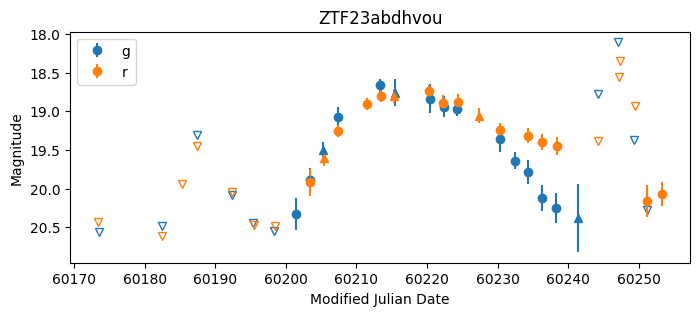


    - Circles (●) with error bars show valid alerts that pass the Fink quality cuts. 
    - Upper triangles with errors (▲), represent alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by classifiers.
    - Lower triangles (▽), represent 5-sigma mag limit in difference image based on PSF-fit photometry contained in the history of valid alerts.
    


In [4]:
pdf = get_fink_data(objectId='ZTF23abdhvou')
plot_lc(pdf)

# plot with sigmoid

In [6]:
from actsnfink import *

In [7]:
def mag2fluxcal_snana(magpsf: float, sigmapsf: float):
    """ Conversion from magnitude to Fluxcal from SNANA manual
    From https://github.com/emilleishida/fink_sn_activelearning/blob/cb61bbb34630c7811862050389b0f993de9639c7/actsnfink/early_sn_classifier.py#L33
    Parameters
    ----------
    magpsf: float
        PSF-fit magnitude from ZTF.
    sigmapsf: float
        Error on PSF-fit magnitude from ZTF. 
    
    Returns
    ----------
    fluxcal: float
        Flux cal as used by SNANA
    fluxcal_err: float
        Absolute error on fluxcal (the derivative has a minus sign)
    """
    if magpsf is None:
        return None, None
    fluxcal = 10 ** (-0.4 * magpsf) * 10 ** (11)
    fluxcal_err = 9.21034 * 10 ** 10 * np.exp(-0.921034 * magpsf) * sigmapsf

    return fluxcal, fluxcal_err

def convert_finkapi_to_actsnfink_fmt(pdf):
    filtdic = {1: "g", 2: "r"}
    lc_flux_sig = pd.DataFrame()
    lc_flux_sig['id'] = pdf['i:objectId'].values.copy()
    lc_flux_sig['type'] = 'unknown'
    lc_flux_sig['MJD'] = pdf['i:jd'].values.copy()
    lc_flux_sig['FLT'] = pdf['i:fid'].apply(lambda x: filtdic[x]).values.copy()

    # converr mag to flux
    f1, f1err = mag2fluxcal_snana(pdf['i:magpsf'].values, pdf['i:sigmapsf'].values)
    lc_flux_sig['FLUXCAL'] = f1
    lc_flux_sig['FLUXCALERR'] = f1err

    return lc_flux_sig





In [14]:
def filter_fink(pdf, with_mag=False, fuptime=None):

    # Step 1: Filter rows where 'd:tag' is 'valid'
    validmags_rows = pdf[pdf['d:tag'] != "upperlim"]
    max_mag = validmags_rows['i:magpsf'].max()
    # Step 2: For 'upperlim', keep only the first occurrence per 'i:fid'
    upperlim_rows = pdf[(pdf['d:tag'] == 'upperlim') & (pdf['i:diffmaglim']>max_mag)].drop_duplicates(subset='i:fid', keep='first')
    upperlim_rows["i:magpsf"] = upperlim_rows["i:diffmaglim"].copy()
    upperlim_rows["i:sigmapsf"] = (
        0.2  # large error for upper limits
    )

    # Step 3: Combine the valid rows with the first occurrences of 'upperlim'
    if with_mag:
        to_plot = pd.concat([validmags_rows, upperlim_rows])
    else:
        to_plot = validmags_rows

    # restrict date
    if fuptime is not None:
        to_plot_out = to_plot[to_plot['i:jd']< fuptime]
    else:
        to_plot_out = to_plot

    return to_plot_out


colordic = {1: "C0", 2: "C1", "g": "C0", "r": "C1"}

def plot_lc_flux_wfit(lc, alerts_features):
    """Plot lc in mag and flux space with fitted sigmoid

    Args:
        lc (pd.DataFrame): light-curve data in FLUX space
        alerts_features (pd.DataFrame): alerts features (sigmoid)
    """
    fig = plt.figure(figsize=(10, 5))

    def sigmoid(t, c, a, b):
        return c / (1 + np.exp(-a * (t - b)))

    JD_fitted = {}
    FLUX_fitted = {}

    for filt in lc["FLT"].unique():
        sel_flt = lc[lc["FLT"] == filt]
        jd = sel_flt.MJD.values - 2400000.5
        flux = sel_flt.FLUXCAL.values
        eflux = sel_flt.FLUXCALERR.values
        plt.errorbar(
            jd,
            flux,
            eflux,
            ls="",
            marker="o",
            color=colordic[filt],
            label=filt,
        )
        # plto sigmoid
        jd_fitted2 = np.linspace(0, max(jd) - min(jd), 1000)
        flux_fitted = get_predicted_flux(
            jd_fitted2,
            alerts_features[f"a_{filt}"].values[0],
            alerts_features[f"b_{filt}"].values[0],
            alerts_features[f"c_{filt}"].values[0],
        )
        plt.plot(jd_fitted2 + min(jd), flux_fitted, color=colordic[filt])

    lcid = lc["id"].values[0]
    lctype = lc["type"].values[0]
    plt.title(f"{lcid} ")
    plt.xlabel("Modified Julian Date")
    plt.ylabel("FLUXCAL")

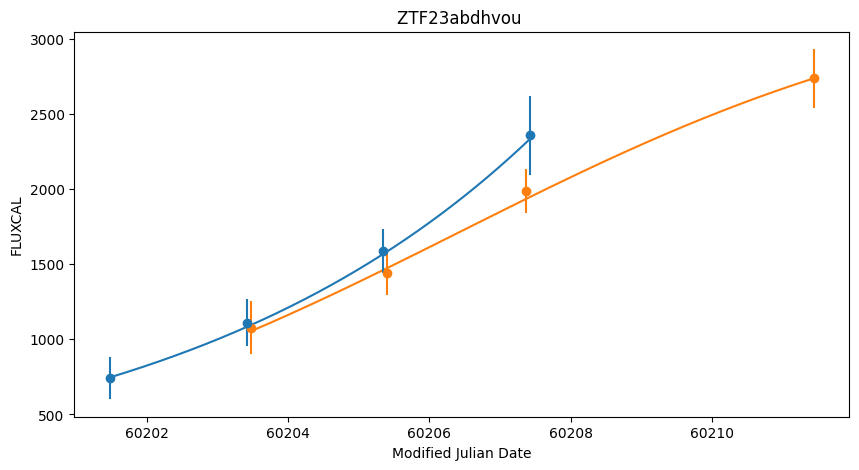

In [18]:
to_plot = filter_fink(pdf, with_mag=False, fuptime=float(Time('2023-09-25', format='iso').jd))
result_fmted = convert_finkapi_to_actsnfink_fmt(to_plot)
# extract features
alerts_features = featurize_full_dataset(
    result_fmted,
    screen=False,
    ewma_window=3,
    min_rising_points=1,
    min_data_points=3,
    rising_criteria="ewma",
)
plot_lc_flux_wfit(result_fmted, alerts_features)

# plot without limits and withm

In [40]:
def sigmoid(t, c, a, b):
    return c / (1 + np.exp(-a * (t - b)))

def from_pdf_to_flux(pdf,with_mag=False):
    to_plot = filter_fink(pdf, with_mag=with_mag, fuptime=float(Time('2023-09-25', format='iso').jd))
    lc = convert_finkapi_to_actsnfink_fmt(to_plot)
    # extract features
    alerts_features = featurize_full_dataset(
        lc,
        screen=False,
        ewma_window=3,
        min_rising_points=1,
        min_data_points=3,
        rising_criteria="ewma",
    )
    return lc, alerts_features

def plot_subplot(lc,alerts_features,ax):

    JD_fitted = {}
    FLUX_fitted = {}
    for filt in lc["FLT"].unique():
        sel_flt = lc[lc["FLT"] == filt]
        jd = sel_flt.MJD.values
        flux = sel_flt.FLUXCAL.values
        eflux = sel_flt.FLUXCALERR.values
        ax.errorbar(
            jd,
            flux,
            eflux,
            ls="",
            marker="o",
            color=colordic[filt],
            label=filt,
        )
        # plto sigmoid
        jd_fitted2 = np.linspace(0, max(jd) - min(jd), 1000)
        flux_fitted = get_predicted_flux(
            jd_fitted2,
            alerts_features[f"a_{filt}"].values[0],
            alerts_features[f"b_{filt}"].values[0],
            alerts_features[f"c_{filt}"].values[0],
        )
        ax.plot(jd_fitted2 + min(jd), flux_fitted, color=colordic[filt])

In [57]:
def plot_lc_flux_wo_wfit(pdf):
    fig = plt.figure(figsize=(10, 5),tight_layout=True)
    gs = fig.add_gridspec(1, 2)
    axs = gs.subplots(sharex=True, sharey=True)

    # with
    lc_wlim,alfeat_wlim = from_pdf_to_flux(pdf,with_mag=True)
    lc_min = lc_wlim['MJD'].min()
    lc_wlim['MJD'] = lc_wlim['MJD'] - lc_min

    plot_subplot(lc_wlim,alfeat_wlim,axs[1])

    
    # wo
    lc1,alfeat1 = from_pdf_to_flux(pdf,with_mag=False)
    lc1['MJD'] = lc1['MJD'] - lc_min
    plot_subplot(lc1,alfeat1,axs[0])
    

    # lcid = lc1["id"].values[0]
    # plt.title(f"{lcid} ")
    axs[0].set_title("Detections only")
    axs[1].set_title("Detections and last limiting magnitude")

    axs[0].set_xlabel("normalised date")
    axs[1].set_xlabel("normalised date")
    axs[0].set_ylabel("FLUXCAL")

    plt.savefig("../plots/example_lc_w_wo_limits.png")

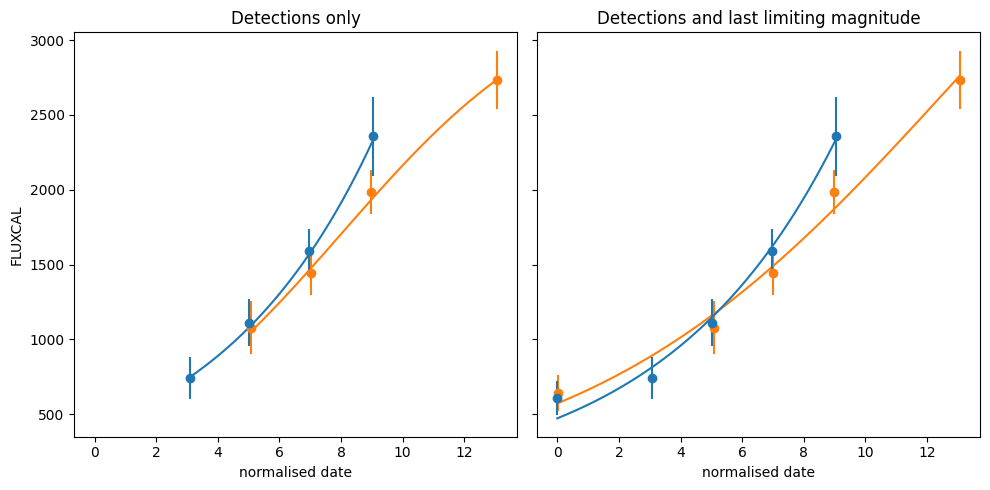

In [58]:
plot_lc_flux_wo_wfit(pdf)
